In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import time

# Generate different kinds of signals
def generate_signal_up(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = np.sin(t) + np.random.normal(0, 0.1, length)
    return signal

# def generate_signal_down(length):
#     t = np.linspace(0, 4 * np.pi, length)
#     # signal = -np.sin(t) + np.random.normal(0, 0.1, length)
#     signal = np.cos(t) + np.random.normal(0, 0.1, length)
#     return signal

def generate_signal_down(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = np.sign(np.cos(t)) + np.random.normal(0, 0.1, length)
    return signal


def generate_signal_left(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = np.cos(t) + np.random.normal(0, 0.1, length)
    return signal

def generate_signal_right(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = -np.cos(t) + np.random.normal(0, 0.1, length)
    return signal

def generate_signal_forward(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = np.sign(np.sin(t)) + np.random.normal(0, 0.1, length)
    return signal

def generate_signal_backward(length):
    t = np.linspace(0, 4 * np.pi, length)
    signal = -np.sign(np.sin(t)) + np.random.normal(0, 0.1, length)
    return signal

In [2]:
# Continuous buffer implementation
class CircularBuffer:
    def __init__(self, size):
        self.buffer = np.zeros(size)
        self.size = size
        self.index = 0

    def add_data(self, data):
        self.buffer[self.index % self.size] = data
        self.index += 1

    def get_data(self):
        if self.index < self.size:
            return self.buffer[:self.index]
        else:
            return self.buffer

# Sliding window function
def sliding_window(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = [data[i * step_size:i * step_size + window_size] for i in range(num_windows)]
    return np.array(windows)

In [3]:
# CNN model
def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

In [4]:
# Parameters
buffer_size = 1024
window_size = 128
step_size = 64
real_time_steps = 10  # number of real-time steps for simulation

# Initialize buffer
buffer = CircularBuffer(buffer_size)

# Generate signals for simulation
length = 1000
signal_up = generate_signal_up(length)
signal_down = generate_signal_down(length)
signal_left = generate_signal_left(length)
signal_right = generate_signal_right(length)
signal_forward = generate_signal_forward(length)
signal_backward = generate_signal_backward(length)

In [5]:
X_train = []
y_train = []

# Generate and add signal segments to training data
for _ in range(50):  # ensure we have enough segments for each class
    for signal_generator, label in zip(
        [generate_signal_up, generate_signal_down], # generate_signal_left, generate_signal_right, generate_signal_forward, generate_signal_backward], 
        range(6)
    ):
        signal_segment = signal_generator(200)
        for i in range(0, len(signal_segment) - window_size, step_size):
            X_train.append(signal_segment[i:i+window_size])
            y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape data for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Shuffle training data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

In [6]:
X_train.shape

(200, 128, 1)

In [7]:
# Create and compile CNN model
cnn_model = create_cnn((window_size, 1))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\ncvn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4759 - loss: 1.3458 - val_accuracy: 0.7250 - val_loss: 0.5676
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7997 - loss: 0.4273 - val_accuracy: 1.0000 - val_loss: 0.3217
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9614 - loss: 0.2175 - val_accuracy: 1.0000 - val_loss: 0.1258
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1006 - val_accuracy: 1.0000 - val_loss: 0.0399
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 9/10


In [8]:
X_val = []
y_val = []

# Generate and add signal segments to validation data
for _ in range(10):
    for signal_generator, label in zip(
        [generate_signal_up, generate_signal_down], #generate_signal_left, generate_signal_right, generate_signal_forward, generate_signal_backward], 
        range(6)
    ):
        signal_segment = signal_generator(200)
        for i in range(0, len(signal_segment) - window_size, step_size):
            X_val.append(signal_segment[i:i+window_size])
            y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Evaluate the model on validation data
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4940e-04 
Validation Accuracy: 100.00%


In [9]:
X_val.shape

(40, 128, 1)

In [10]:
# Real-time incoming signals simulation
incoming_signal_length = 1000

# Generate a new signal that randomly switches between the six types with random segment lengths
real_time_signals = []
real_labels = []
current_length = 0

while current_length < incoming_signal_length:
    segment_length = np.random.randint(128,130)
    signal_type = np.random.choice(2)
    if signal_type == 0:
        real_time_signals.extend(generate_signal_up(segment_length))
        real_labels.extend([0] * segment_length)
    elif signal_type == 1:
        real_time_signals.extend(generate_signal_down(segment_length))
        real_labels.extend([1] * segment_length)
    elif signal_type == 2:
        real_time_signals.extend(generate_signal_left(segment_length))
        real_labels.extend([2] * segment_length)
    elif signal_type == 3:
        real_time_signals.extend(generate_signal_right(segment_length))
        real_labels.extend([3] * segment_length)
    elif signal_type == 4:
        real_time_signals.extend(generate_signal_forward(segment_length))
        real_labels.extend([4] * segment_length)
    else:
        real_time_signals.extend(generate_signal_backward(segment_length))
        real_labels.extend([5] * segment_length)
    current_length += segment_length

real_time_signals = np.array(real_time_signals[:incoming_signal_length])
real_labels = np.array(real_labels[:incoming_signal_length])

# Initialize real-time buffer
real_time_buffer = CircularBuffer(buffer_size)

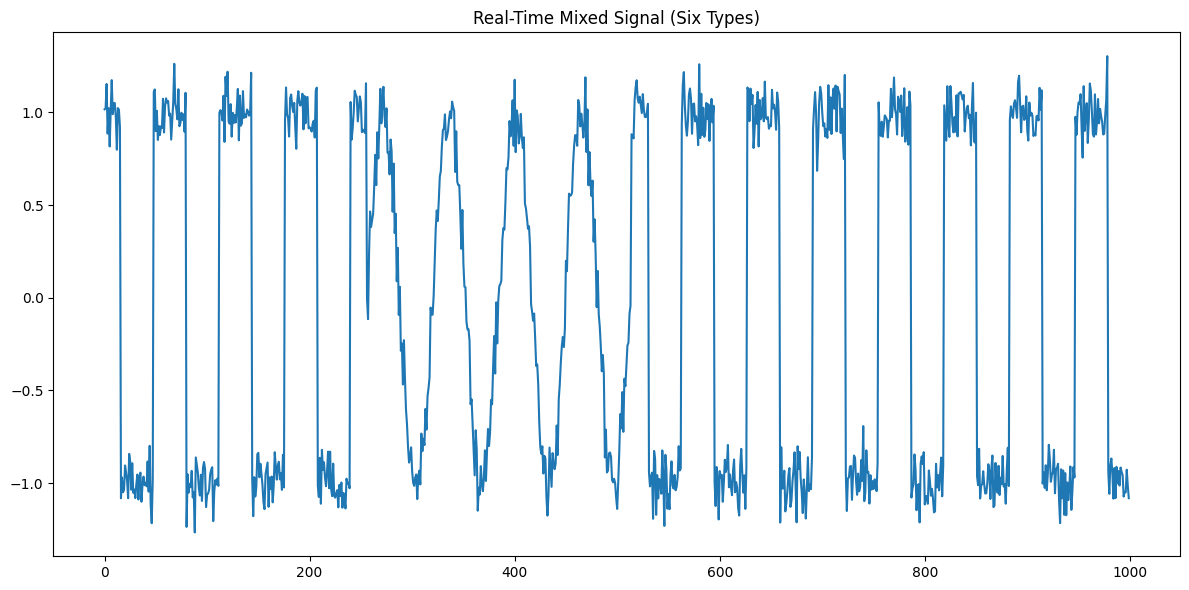

In [11]:

# Plot the signals
plt.figure(figsize=(12, 6))
plt.plot(real_time_signals)
plt.title("Real-Time Mixed Signal (Six Types)")
plt.tight_layout()
plt.show()

In [ ]:
import websocket
import time
import numpy as np

# Example simulation loop for real-time data transmission
correct_sections = 0
total_sections = 0
previous_label = None
correct_section_detected = False

# WebSocket connection to ESP32-CAM server
ws = websocket.WebSocket()
ws.connect("ws://192.168.4.1:81")  # Replace with your ESP32 IP address and WebSocket port

def send_data(ws, data):
    try:
        # Send the predicted class through the WebSocket connection
        ws.send(data)
    except Exception as e:
        print(f"Failed to send data: {e}")

# Real-time simulation variables
i = 0
# Real-time processing loop with incoming data
while i < incoming_signal_length:
    real_time_buffer.add_data(real_time_signals[i])
    if real_time_buffer.index >= window_size:
        window_data = real_time_buffer.get_data()[-window_size:].reshape(1, window_size, 1)
        prediction = cnn_model.predict(window_data, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        real_label = real_labels[i]
        print(f"Predicted action: {predicted_class}, True action: {real_label}")

        # Send the predicted class to the ESP32 server through WebSocket
        send_data(ws, str(predicted_class))

        if previous_label is not None and real_label != previous_label:
            total_sections += 1
            if correct_section_detected:
                correct_sections += 1
            correct_section_detected = False

        if not correct_section_detected and predicted_class == real_label:
            correct_section_detected = True

        previous_label = real_label

    i += 1
    time.sleep(0.01)  # Simulate real-time delay

if correct_section_detected:
    total_sections += 1
    correct_sections += 1

print(f"Total Sections: {total_sections}")
print(f"Correctly Detected Sections: {correct_sections}")
print(f"Accuracy: {correct_sections / total_sections * 100:.2f}%")

# Close WebSocket connection when done
ws.close()


In [12]:
import socket
import time
import numpy as np

# ESP32 IP address and port
ESP32_IP = '192.168.4.1'
PORT = 80

# Example simulation loop for real-time data transmission
correct_sections = 0
total_sections = 0
previous_label = None
correct_section_detected = False

def send_data(sock, data):
    try:
        # Send the HTTP GET request exactly as it is, without modification
        sock.sendall(data.encode('utf-8'))
    except Exception as e:
        print(f"Failed to send data: {e}")

# Real-time simulation variables
i = 0
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
    # Connect to ESP32 at the specified IP and port
    sock.connect((ESP32_IP, PORT))
    print('Connected to ESP32')

    # Real-time processing loop with incoming data
    while i < incoming_signal_length:
        real_time_buffer.add_data(real_time_signals[i])
        if real_time_buffer.index >= window_size:
            window_data = real_time_buffer.get_data()[-window_size:].reshape(1, window_size, 1)
            prediction = cnn_model.predict(window_data, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            real_label = real_labels[i]
            print(f"Predicted action: {predicted_class}, True action: {real_label}")

            # Send the predicted class to the ESP32 server exactly as requested
            send_data(sock, f"GET /prediction?value={predicted_class} HTTP/1.1\r\n")

            if previous_label is not None and real_label != previous_label:
                total_sections += 1
                if correct_section_detected:
                    correct_sections += 1
                correct_section_detected = False

            if not correct_section_detected and predicted_class == real_label:
                correct_section_detected = True

            previous_label = real_label

        i += 1
        time.sleep(0.01)  # Simulate real-time delay

    if correct_section_detected:
        total_sections += 1
        correct_sections += 1

print(f"Total Sections: {total_sections}")
print(f"Correctly Detected Sections: {correct_sections}")
print(f"Accuracy: {correct_sections / total_sections * 100:.2f}%")


TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [ ]:
# Real-time simulation loop with while loop
correct_sections = 0
total_sections = 0
previous_label = None
correct_section_detected = False
import socket

def send_data(sock, data):
    try:
        sock.sendall(data.encode('utf-8'))
    except Exception as e:
        print(f"Failed to send data: {e}")


i = 0
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
    sock.connect(('127.0.0.1', 50000))
    print('Connected to Unity')
    while i < incoming_signal_length:
        real_time_buffer.add_data(real_time_signals[i])
        if real_time_buffer.index >= window_size:
            window_data = real_time_buffer.get_data()[-window_size:].reshape(1, window_size, 1)
            prediction = cnn_model.predict(window_data, verbose=0)  # Disable verbose output
            predicted_class = np.argmax(prediction, axis=1)[0]
            real_label = real_labels[i]

            data_str = f"Predicted action: {predicted_class}, True action: {real_label}"
            #print(data_str)  # Print predictions and actual labels for verification
            send_data(sock, str(predicted_class))  # Send predicted class to the server

            # Check for section change
            if previous_label is not None and real_label != previous_label:
                total_sections += 1
                if correct_section_detected:
                    correct_sections += 1
                correct_section_detected = False

            # Check if current section is correct
            if not correct_section_detected and predicted_class == real_label:
                correct_section_detected = True

            previous_label = real_label

        i += 1
        time.sleep(0.01)  # Simulate real-time delay

    # Final section check
    if correct_section_detected:
        total_sections += 1
        correct_sections += 1

print(f"Total Sections: {total_sections}")
print(f"Correctly Detected Sections: {correct_sections}")
print(f"Accuracy: {correct_sections / total_sections * 100:.2f}%")


In [2]:
import socket
import time
import keyboard  # for keyboard control

class RobotCar:
    def __init__(self, ip_address, port=80):
        self.ip = ip_address
        self.port = port
        
    def send_command(self, command):
        try:
            # Create a socket connection
            sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            sock.connect((self.ip, self.port))
            
            # HTTP GET request
            request = f"GET /{command} HTTP/1.1\r\nHost: {self.ip}\r\n\r\n"
            sock.send(request.encode())
            
            # Close the connection
            sock.close()
            print(f"Sent command: {command}")
            
        except Exception as e:
            print(f"Error sending command: {e}")
            
    def forward(self):
        self.send_command('F')
        
    def backward(self):
        self.send_command('B')
        
    def left(self):
        self.send_command('L')
        
    def right(self):
        self.send_command('R')
        
    def stop(self):
        self.send_command('S')

def main():
    # Replace with your car's IP address from Serial Monitor
    car_ip = "192.168.1.100"  # CHANGE THIS TO YOUR CAR'S IP
    car = RobotCar(car_ip)
    
    print("Robot Car Control")
    print("----------------")
    print("Use arrow keys to control the car:")
    print("↑ - Forward")
    print("↓ - Backward")
    print("← - Left")
    print("→ - Right")
    print("Space - Stop")
    print("Q - Quit")
    print("----------------")
    
    try:
        while True:
            if keyboard.is_pressed('up'):
                car.forward()
                time.sleep(0.1)  # Delay to prevent too many commands
            elif keyboard.is_pressed('down'):
                car.backward()
                time.sleep(0.1)
            elif keyboard.is_pressed('left'):
                car.left()
                time.sleep(0.1)
            elif keyboard.is_pressed('right'):
                car.right()
                time.sleep(0.1)
            elif keyboard.is_pressed('space'):
                car.stop()
                time.sleep(0.1)
            elif keyboard.is_pressed('q'):
                print("Quitting...")
                break
                
    except KeyboardInterrupt:
        print("\nProgram terminated by user")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Robot Car Control
----------------
Use arrow keys to control the car:
↑ - Forward
↓ - Backward
← - Left
→ - Right
Space - Stop
Q - Quit
----------------

Program terminated by user


In [ ]:
import socket
import time

def test_connection(ip_address, port=80):
    print(f"Testing connection to car at {ip_address}:{port}")
    
    commands = ['F', 'B', 'L', 'R', 'S']
    
    for cmd in commands:
        try:
            # Create socket
            sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            sock.connect((ip_address, port))
            
            # Send command
            request = f"GET /{cmd} HTTP/1.1\r\nHost: {ip_address}\r\n\r\n"
            sock.send(request.encode())
            
            print(f"Successfully sent command: {cmd}")
            sock.close()
            time.sleep(1)  # Wait between commands
            
        except Exception as e:
            print(f"Error with command {cmd}: {e}")
            return False
    
    return True

if __name__ == "__main__":
    car_ip = "192.168.1.100"  # CHANGE THIS TO YOUR CAR'S IP
    
    if test_connection(car_ip):
        print("\nAll tests passed! Car is responding to commands.")
    else:
        print("\nTest failed. Check IP address and car's WiFi connection.")